In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(umap)
library(patchwork)
library(ggExtra) 
library(pals)
library(RColorBrewer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [2]:
filtered <- read.table("../20230101_QC/final_summary_anno3.txt",header=T,sep="\t")

filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use Mosaic or Mosaic_shared_btw_WGS_Amp
variant_list<-unique(filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,]$CHROM.POS.REF.ALT) #Use Mosaic or Mosaic_shared_btw_WGS_Amp
variant_list<-as.data.frame(variant_list, row.names = variant_list )
variant_list$sample_number_presented <- NA

for (i in 1:nrow(variant_list)){
    filtered2 <- filtered[filtered$CHROM.POS.REF.ALT == variant_list[i,]$variant_list,]
    n_row <- nrow(filtered2[filtered[filtered$CHROM.POS.REF.ALT == variant_list[i,]$variant_list,]$LOWER_CI>0.002360687 & 
          filtered[filtered$CHROM.POS.REF.ALT == variant_list[i,]$variant_list,]$UPPER_CI<0.4562841,])
    variant_list$sample_number_presented[i] <- n_row
    }

In [5]:
unique(mosaic_filtered$Organ)

[1] "HEART"   "ADRENAL" "CB"      "CTX"     "LIVER"   "KIDNEY"  "POA"    
 [8] "BG"      "THAL"    "HIP"     "SKIN"    "OLF"     "JGG"

In [12]:
 shared_variant_list<-variant_list[variant_list$sample_number_presented>0,]
 shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
# shared_mosaic_filtered <- subset(shared_mosaic_filtered, Organ %in% c('CTX','BG','THAL','CB','HIP','OLF','POA')
#                               # &(Cell_Type %in% c('Bulk','TBR1','DLX1','COUPTF2','LHX2','Olig2')) 
#                               # & (Hemisphere %in% c('L'))
#                                )
# melt_mtcars<-shared_mosaic_filtered[,c("ID", "MAF","Hemisphere","Region", "CHROM.POS.REF.ALT","Cell_Type","Organ")]
# melt_mtcars<-na.omit(melt_mtcars)
# melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

melt_mtcars<-shared_mosaic_filtered[,c("ID", "MAF", "CHROM.POS.REF.ALT","Cell_Type","Organ",'Region','Punch','Hemisphere')]
#melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% variant_list[variant_list$sample_number_presented>1,]$variant_list,])
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('DLX1'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Organ %in% c('CTX','BG','HIP','THAL',"OLF","POA","CB"),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Organ %in% c('CTX'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('R'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1','2','3','4','5','6','7','8','9','10','11','12',
#                                                  '13','14','15','16','17') ,]
#melt_mtcars<-melt_mtcars[!melt_mtcars$Punch %in% c('3','4','5','6','7','8','9','10','11','12',
#                                                  '13','14','15','16','17'),]
#melt_mtcars<-melt_mtcars[!(melt_mtcars$Punch %in% c('2') & melt_mtcars$Region %in% c('O','P','I')),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Cell_Type+Organ~CHROM.POS.REF.ALT, value.var = "MAF",na.rm=T)
rownames(casted_MAF_VarBySample)<-casted_MAF_VarBySample$ID
casted_MAF_VarBySample2<-casted_MAF_VarBySample[,-1:-5]
label<-casted_MAF_VarBySample[,1:5]
UMAP<-umap(casted_MAF_VarBySample2)
df<-as.data.frame(UMAP$layout)
df<-cbind(df,label)

In [13]:
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=10)
p1<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color = Cell_Type, shape = Hemisphere),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position = c(0.93, 0.2))
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=5)
p2<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color = Organ),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), legend.position = c(0.93, 0.2))
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=5)
p3<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color = Region),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), legend.position = c(0.93, 0.2))

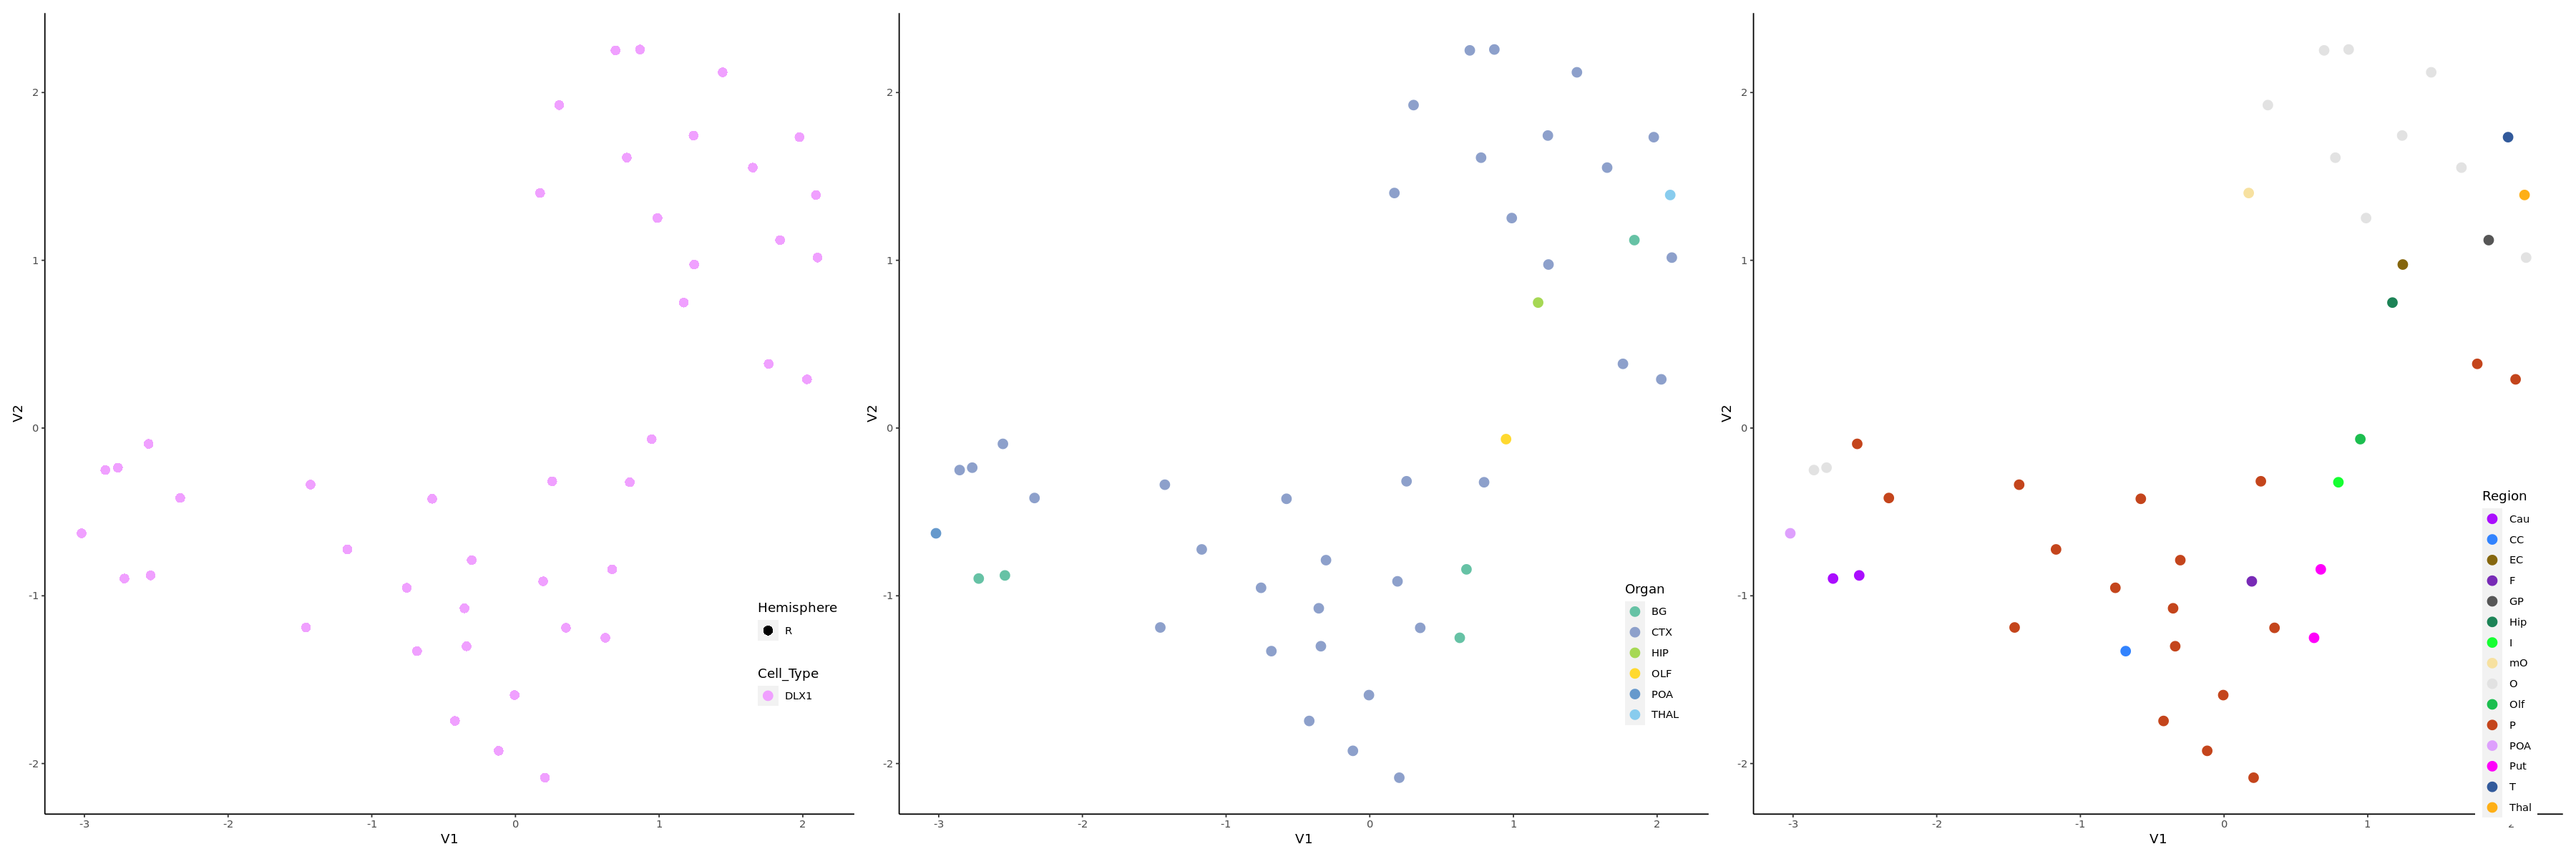

In [14]:
options(repr.plot.width=30,repr.plot.height=10)
p<-p1+scale_colour_manual(values = c('#F0A0FF','#0075DC','#FF5005','#2BCE48','#426600') )+
p2+scale_colour_manual(values = c("#66C2A5","#8DA0CB","#A6D854","#FFD92F","#6699CC","#88CCEE","#B3B3B3"))+
p3+scale_colour_manual(values = c('#AA0DFE','#3283FE','#85660D','#782AB6','#565656','#1C8356','#16FF32','#F7E1A0','#E2E2E2','#1CBE4F','#C4451C','#DEA0FD','#FE00FA',
                                 '#325A9B','#FEAF16','#F8A19F','#90AD1C','#F6222E','#1CFFCE','#2ED9FF','#B10DA1','#C075A6') )
p

In [29]:
pdf(file="7669_Brain_CTX_BG_HIP_THAL_UMAP.pdf",height=10,width=30)
p
dev.off()

png 
  2

In [51]:
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(variant_list),]
shared_mosaic_filtered <- subset(shared_mosaic_filtered, Organ %in% c('CTX')
                               &(Cell_Type %in% c('TBR1','DLX1')) 
                               & (Hemisphere %in% c('R')) & Region=='P'
                               )
melt_mtcars<-shared_mosaic_filtered[,c("ID", "MAF","Hemisphere","Punch", "CHROM.POS.REF.ALT","Cell_Type","Organ")]
melt_mtcars<-na.omit(melt_mtcars)
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Punch+Cell_Type+Organ~CHROM.POS.REF.ALT, value.var = "MAF",na.rm=T)
rownames(casted_MAF_VarBySample)<-casted_MAF_VarBySample$ID
casted_MAF_VarBySample2<-casted_MAF_VarBySample[,-1:-5]
label<-casted_MAF_VarBySample[,1:5]
UMAP<-umap(casted_MAF_VarBySample2)
df<-as.data.frame(UMAP$layout)
df<-cbind(df,label)
df$Punch <- factor(df$Punch, levels = c(1:17))

In [53]:
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=10)
p1<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color =Punch , shape = Cell_Type),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),legend.position = "top")
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=5)
p2<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color = Organ),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), legend.position = c(0.93, 0.8))
# variants grouping by umap
options(repr.plot.width=10,repr.plot.height=5)
p3<-ggplot(df, aes(x = V1, y = V2))+ 
geom_point(
    aes(color = Region),
    size = 3.5, 
    alpha = 1 # It's nice to add some transparency because there may be overlap.
  )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), legend.position = c(0.93, 0.7))

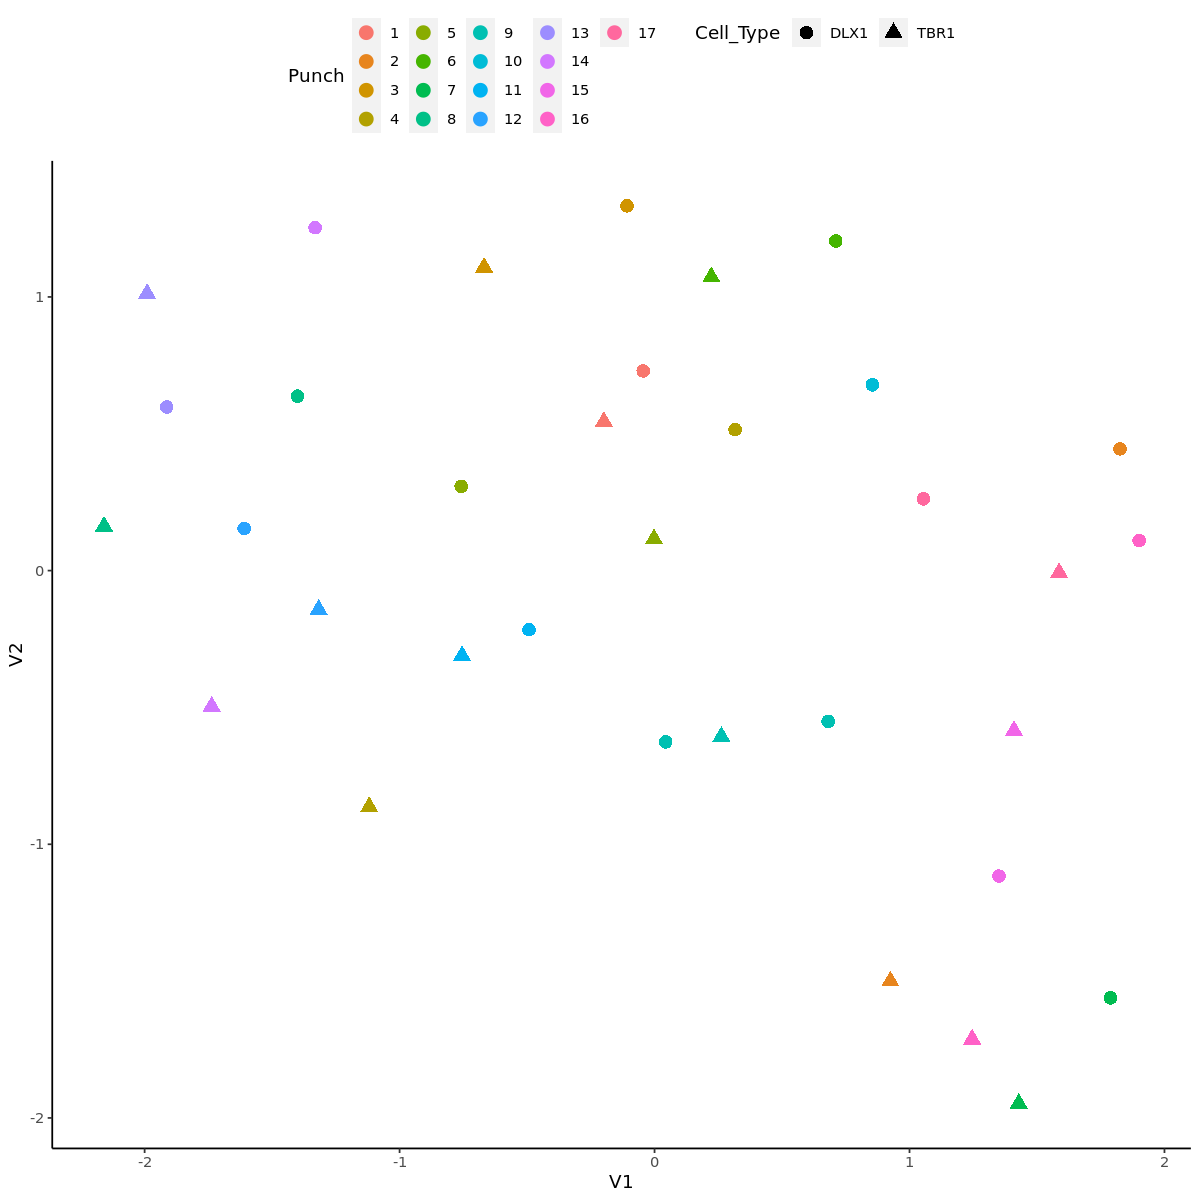

In [54]:
options(repr.plot.width=10,repr.plot.height=10)
p1

In [57]:
pdf(file="7669_Brain_CTX_Right_P_DLX1_TBR1_UMAP.pdf",height=10,width=10)
p1
dev.off()

png 
  2